# Using trained model at Various Checkpoints to Evaluate on Train and Test Set

In [357]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import time
import pickle
from PIL import Image
import matplotlib.pyplot as plt
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
print(tf.__version__)

2.4.1


In [358]:
from tensorflow.keras.models import load_model

## Loading Model Architecture

In [359]:
saved_model_path = r'results/30k_i_res_v2'


In [360]:
model_arch_path = os.path.join(saved_model_path, 'model_architecture')
encoder_path = os.path.join(model_arch_path,'encoder')
decoder_path = os.path.join(model_arch_path,'decoder')
attention_path = os.path.join(model_arch_path,'attention')
embedder_path = os.path.join(model_arch_path,'embedder')

In [361]:
encoder = load_model(encoder_path)


In [362]:
decoder = load_model(decoder_path)
decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attn_context (InputLayer)       [(None, 256)]        0                                            
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 556)          0           attn_context[0][0]               
                                                                 dec_input[0][0]                  
__________________________________________________________________________________________________
hiden_state (InputLayer)        [(None, 512)]        0                                      

In [363]:
lstm_num_units = decoder.get_layer('hiden_state').output_shape[0][1]
lstm_num_units

512

In [364]:
attention = load_model(attention_path)


In [365]:
embedder = load_model(embedder_path)


## Loading saved weights at desired checkpoint

In [366]:
def load_checkpoint_num(num, encoder, embedder, decoder, attention, saved_model_path):
    checkpoint_num = "ckpt-" + str(num)
    checkpoint_path = os.path.join(saved_model_path,checkpoint_num)
    ckpt = tf.train.Checkpoint(encoder_model=encoder,
                           glove_word_embedder = embedder,
                           attention_model = attention,
                           decoder_model=decoder)
    status = ckpt.restore(checkpoint_path)
    return ckpt

In [367]:
saved_checkpoint_path = os.path.join(saved_model_path,'model')

In [368]:
ckpt = load_checkpoint_num(num=2, encoder=encoder, embedder=embedder, decoder=decoder, attention=attention, saved_model_path=saved_checkpoint_path)

## Load Appropriate Tokenizer

In [369]:
#load tokenizer
tokenizer_path = r'data/30k_sample/tokenizer.pickle'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

## Utility Methods for evaluating

### Captioning an image

In [370]:
def caption(image_index,emb_path, checkpoint):
    """
    Captions the image with the given index using image embeddings in the given embeddings directory
    """
    embedding = np.load(emb_path)
    embedding = tf.expand_dims(embedding, 0)
    
    max_len = 50
    lstm_hidden = tf.zeros((1, lstm_num_units))
    lstm_cell = tf.zeros((1, lstm_num_units))
    #first token is always start token.
    start_index = tokenizer.word_index['<start>']
    word_token = np.full((1,1), start_index, dtype=np.int32)
    
    
    image_enc = checkpoint.encoder_model(embedding)
    
    caption = []
    for i in range(max_len):
    
        img_context, attn_weights = checkpoint.attention_model([image_enc, lstm_hidden])
        dec_input = checkpoint.glove_word_embedder(word_token)
        dec_output, lstm_hidden, lstm_cell = checkpoint.decoder_model((dec_input, img_context,lstm_hidden,lstm_cell))
        
        #sample a word based on the word with max probability improvement: BEAM SEARCH??
        #we tried doing categorical sampling but it was really bad
        word_token = tf.argmax(dec_output, 1)[0].numpy()
        #word_token =tf.random.categorical(dec_output, 1)[0][0].numpy()

        word = tokenizer.index_word[word_token]
        word_token = np.full((1,1), word_token, dtype=np.int32)
        
        caption.append(word)
        
        if(word == '<end>'):
            return caption
        
    return caption

### Displaying a random assortment of samples

In [371]:
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = seed)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        pred_caption = " ".join(row['pred_captions'])
        
        title_str = f"Actual Caption: {caption}\n Generated Caption: {pred_caption}"
        
        image = Image.open(file_name)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image)        
        plt.suptitle(title_str)

        plt.xticks([])
        plt.yticks([])
        plt.show()

### Finding bleu score given predicted and generated caption

In [372]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
def get_bleu(tok_pred, tok_true):
    """
    Given tokenized real and generated captions, returns bleu score
    """
    #remove the end token for pred and both start and end token for true
    tok_pred = tok_pred[:-1]
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    if(len(tok_pred)) == 1:
        return 0
    return nltk.bleu_score.sentence_bleu([tok_true], tok_pred,smoothing_function=smoothie) 

### Finding meteor score given predicted and generated caption

In [373]:
from nltk.translate.meteor_score import single_meteor_score as meteor 

def get_meteor(tok_pred,tok_true):
    tok_pred = tok_pred[:-1]
    tok_pred = " ".join(tok_pred)
    #tok_true = tok_true.replace('.','')
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    tok_true = " ".join(tok_true)
    return meteor(tok_true,tok_pred)

### Finding rouge score given predicted and generated caption



In [374]:
from rouge_score import rouge_scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)


In [375]:
def get_rouge1(tok_pred, tok_true, scorer):
    tok_pred = tok_pred[:-1]
    tok_pred = " ".join(tok_pred)
    #tok_true = tok_true.replace('.','')
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    tok_true = " ".join(tok_true)
    
    score = scorer.score(tok_true,tok_pred)
    return score['rouge1'][2]
    
    
    

In [376]:
def get_rougeL(tok_pred, tok_true, scorer):
    tok_pred = tok_pred[:-1]
    tok_pred = " ".join(tok_pred)
    #tok_true = tok_true.replace('.','')
    tok_true = tok_true[1:]
    tok_true = tok_true[:-1]
    tok_true = [tokenizer.index_word[tok] for tok in tok_true]
    tok_true = " ".join(tok_true)
    
    score = scorer.score(tok_true,tok_pred)
    return score['rougeL'][2]
    

## Evaluating on Training Data

### Load tokenized and sent added training dataframe with path to embeddings

In [377]:
#load dataframe
#path to file containing dataframe
df_path = r'data/30k_sample/tokenized_sent_added_emb'

In [378]:
train_df = pd.read_csv(df_path, converters={'captions_tokenized_padded': eval, 'captions_tokenized':eval})

In [379]:
train_df.columns

Index(['global_index', 'caption', 'link', 'objects', 'mid',
       'object_confidences', 'image_path', 'size', 'height', 'width',
       'aspect_ratio', 'num_obj', 'nltk_sent_polarity', 'nltk_sent',
       'nltk_sent_pos_neg', 'nltk_sent_pos_neg_conf', 'hf_sent',
       'hf_sent_class', 'hf_sent_conf', 'captions_processed',
       'captions_tokenized', 'captions_tokenized_padded', 'i_v3_embed_path',
       'i_resnet_v2_embed_path'],
      dtype='object')

### Sample and predict captions

In [380]:
emb_type = 'i_resnet_v2_embed_path'

In [381]:
train_sample = train_df.sample(100, random_state=0)
train_sample['pred_captions'] = train_sample.apply(lambda x: caption(x['global_index'], x[emb_type], ckpt), axis=1)


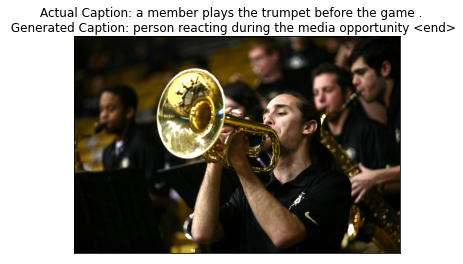

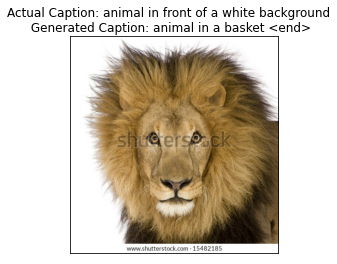

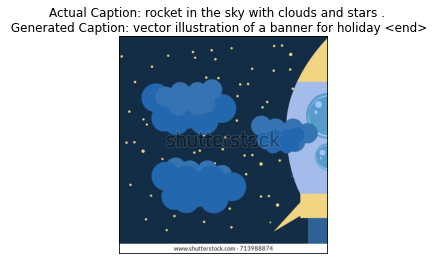

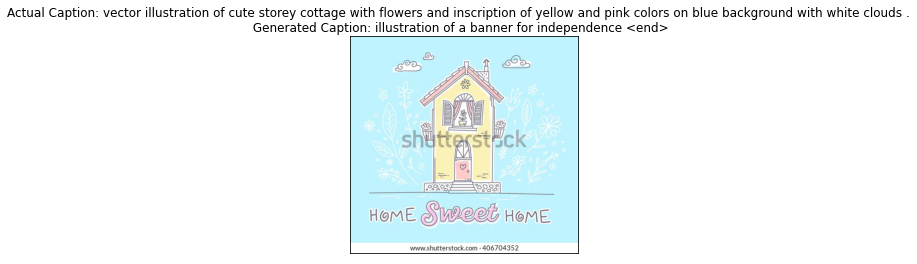

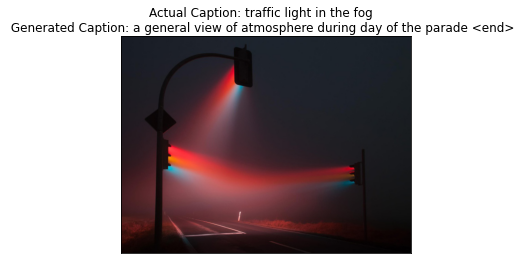

In [382]:
display_samples(train_sample)

### Find Bleu Score

In [383]:
train_sample['bleu_scores'] = train_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)

In [384]:
train_sample['bleu_scores'].describe()

count    100.000000
mean       0.386315
std        0.273852
min        0.000000
25%        0.215853
50%        0.355928
75%        0.579827
max        1.016396
Name: bleu_scores, dtype: float64

### Find meteor score 

In [385]:
train_sample['meteor_scores'] = train_sample.apply(lambda x: get_meteor( x.pred_captions, x.captions_tokenized), axis = 1)

In [386]:
train_sample['meteor_scores'].describe()

count    100.000000
mean       0.184574
std        0.242177
min        0.000000
25%        0.050134
50%        0.084746
75%        0.245823
max        0.999711
Name: meteor_scores, dtype: float64

### Find Rouge 1 score

In [387]:
train_sample['rouge1_scores'] = train_sample.apply(lambda x: get_rouge1( x.pred_captions, x.captions_tokenized, rouge_scorer), axis = 1)

In [388]:
train_sample['rouge1_scores'].describe()

count    100.000000
mean       0.246809
std        0.238408
min        0.000000
25%        0.109649
50%        0.177866
75%        0.352941
max        1.000000
Name: rouge1_scores, dtype: float64

### Find Rouge L score



In [389]:
train_sample['rougeL_scores'] = train_sample.apply(lambda x: get_rougeL( x.pred_captions, x.captions_tokenized, rouge_scorer), axis = 1)



In [390]:
train_sample['rougeL_scores'].describe()

count    100.000000
mean       0.242924
std        0.237295
min        0.000000
25%        0.105263
50%        0.177866
75%        0.338235
max        1.000000
Name: rougeL_scores, dtype: float64

## Evaluating on Test Data

### Load tokenized and sent added testing dataframe with path to embeddings

In [391]:
#load dataframe
#path to file containing dataframe
df_path = r'data/initial_sample/tokenized_sent_added_emb'

In [392]:
test_df = pd.read_csv(df_path, converters={'captions_tokenized_padded': eval, 'captions_tokenized':eval})

In [393]:
test_df.columns

Index(['caption', 'link', 'objects', 'mid', 'object_confidences', 'image_path',
       'global_index', 'size', 'height', 'width', 'aspect_ratio', 'num_obj',
       'nltk_sent_polarity', 'nltk_sent', 'nltk_sent_pos_neg',
       'nltk_sent_pos_neg_conf', 'hf_sent', 'hf_sent_class', 'hf_sent_conf',
       'captions_processed', 'captions_tokenized', 'captions_tokenized_padded',
       'i_v3_embed_path', 'i_resnet_v2_embed_path'],
      dtype='object')

### Sample and predict captions

In [394]:
test_sample = test_df.sample(5000, random_state=0)
test_sample['pred_captions'] = test_sample.apply(lambda x: caption(x['global_index'], x[emb_type], ckpt), axis=1)


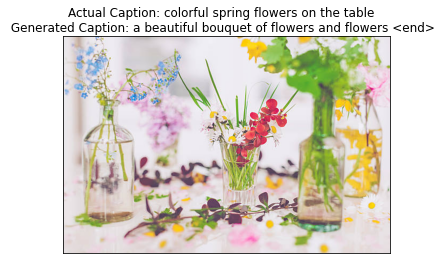

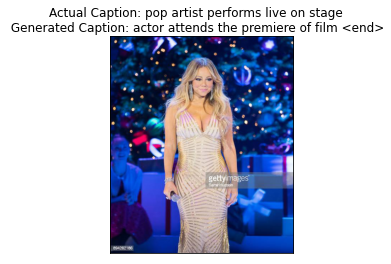

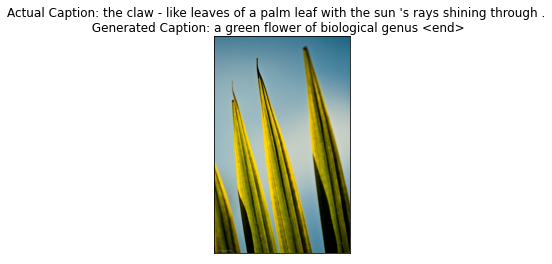

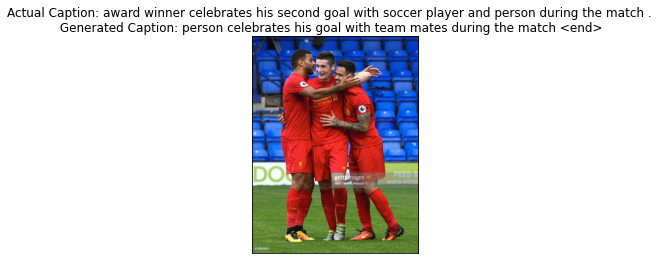

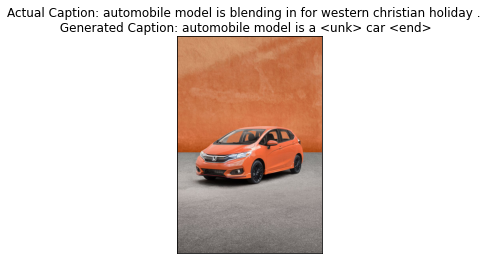

In [395]:
display_samples(test_sample, seed=12)

### Find Bleu Score

In [396]:
test_sample['bleu_scores'] = test_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)

In [397]:
test_sample['bleu_scores'].describe()

count    5000.000000
mean        0.349402
std         0.274943
min         0.000000
25%         0.099137
50%         0.337742
75%         0.543106
max         1.512355
Name: bleu_scores, dtype: float64

### Find meteor score 

In [398]:
test_sample['meteor_scores'] = test_sample.apply(lambda x: get_meteor( x.pred_captions, x.captions_tokenized), axis = 1)

In [399]:
test_sample['meteor_scores'].describe()

count    5000.000000
mean        0.134040
std         0.166565
min         0.000000
25%         0.040984
50%         0.081967
75%         0.156383
max         1.078579
Name: meteor_scores, dtype: float64

### Find Rouge 1 score

In [400]:
test_sample['rouge1_scores'] = test_sample.apply(lambda x: get_rouge1( x.pred_captions, x.captions_tokenized, rouge_scorer), axis = 1)

In [401]:
test_sample['rouge1_scores'].describe()

count    5000.000000
mean        0.203211
std         0.179254
min         0.000000
25%         0.095238
50%         0.166667
75%         0.285714
max         1.000000
Name: rouge1_scores, dtype: float64

### Find Rouge L score



In [402]:
test_sample['rougeL_scores'] = test_sample.apply(lambda x: get_rougeL( x.pred_captions, x.captions_tokenized, rouge_scorer), axis = 1)



In [356]:
test_sample['rougeL_scores'].describe()

count    5000.000000
mean        0.142896
std         0.136535
min         0.000000
25%         0.000000
50%         0.125000
75%         0.200000
max         1.000000
Name: rougeL_scores, dtype: float64

## Plot bleu accross epochs for train and test 

In [48]:
def plot_metrics_accross_epoch(nums, sample_size, train_data, test_data):
#     metrics = pd.DataFrame(columns = ['epoch', 'train_bleu', 'test_bleu' 'train_meteor', 'test_meteor',
#                                      'train_rouge1', 'test_rouge1' 'train_rougeL', 'test_rougeL'])
    metrics = pd.DataFrame(columns=['epoch', 'train_bleu','test_bleu'])
    train_sample = train_data.sample(sample_size, random_state = 0)
    test_sample = test_data.sample(sample_size, random_state = 0)
    
    for num in nums:
        print("-----------NUM--------", num)
        ckpt = load_checkpoint_num(num=num, encoder=encoder, embedder=embedder, decoder=decoder, attention=attention, saved_model_path=saved_checkpoint_path)
        epoch = num*5
        
        #predict captions on train and test
        train_sample['pred_captions'] = train_sample.apply(lambda x: caption(x['global_index'], x[emb_type], ckpt), axis=1)
        test_sample['pred_captions'] = test_sample.apply(lambda x: caption(x['global_index'], x[emb_type], ckpt), axis=1)
        
        #calculate bleu scores
        train_sample['bleu_scores'] = train_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)
        test_sample['bleu_scores'] = test_sample.apply(lambda x: get_bleu( x.pred_captions, x.captions_tokenized), axis = 1)
        
        train_bleu = train_sample['bleu_scores'].mean()
        test_bleu = test_sample['bleu_scores'].mean()
        
        metrics = metrics.append({'epoch':epoch, 'train_bleu': train_bleu, 'test_bleu': test_bleu}, ignore_index=True)
    return metrics
        

In [ ]:
metrics = plot_metrics_accross_epoch([1,2,3,4,5], 5000, train_df, test_df)

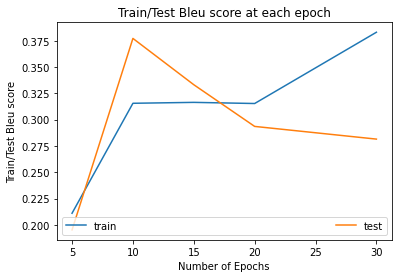

In [53]:
ax = plt.subplot()

plt.plot(metrics['epoch'], metrics['train_bleu'], label="train")
plt.plot(metrics['epoch'], metrics['test_bleu'], label="test")
plt.xlabel("Number of Epochs")
plt.ylabel("Train/Test Bleu score")
plt.title("Train/Test Bleu score at each epoch")
leg = plt.legend(loc='best', ncol=2, mode="expand", fancybox=True)


plt.show()